# Classifying Valid Routes
<p>This document is a testing ground for various classifiers in regards to classifying output from the "show ip route [ipv6 address]" command from a Cisco router. Each route will be classified as good or bad. Testing data is generated from a template parsed by the Jinja2 library.</p>

<p>This project was inspired by sentdex's [Natural Language Processing tutorial series on Youtube] (https://www.youtube.com/watch?v=FLZvOKSCkxY&list=PLQVvvaa0QuDf2JswnfiGkliBInZnIC4HL).</p>

In [1]:
import nltk
import random
import pickle


good_data = open('Datasets/good_routes', 'r').read()
bad_data1 = open('Datasets/bad_routes1', 'r').read()
bad_data2 = open('Datasets/bad_routes2', 'r').read()

documents = []

for r in good_data.split('\n'):
    documents.append((r, 'good'))
    
for r in bad_data1.split('\n'):
    documents.append((r, 'bad'))
    
for r in bad_data2.split('\n'):
    documents.append((r, 'bad'))

good_words = nltk.word_tokenize(good_data)
bad_words1 = nltk.word_tokenize(bad_data1)
bad_words2 = nltk.word_tokenize(bad_data2)

all_words = []

for w in good_words:
    all_words.append(w.lower())
    
for w in bad_words1:
    all_words.append(w.lower())
    
for w in bad_words2:
    all_words.append(w.lower())


all_words = nltk.FreqDist(all_words)
word_features = list(all_words.keys())

s_word_features = open("Util/word_features.pickle", "wb")
pickle.dump(word_features, s_word_features)

def find_features(document):
    words = nltk.word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features

featuresets = [(find_features(route), tag) for (route, tag) in documents]
random.shuffle(featuresets)
train_set, test_set = featuresets[:1000], featuresets[1000:]

print("Documents Len:", len(documents))
print("Feature Set Len:", len(featuresets))
print("Train Set Len:", len(train_set))
print("Test Set Len:", len(test_set))




Documents Len: 4003
Feature Set Len: 4003
Train Set Len: 1000
Test Set Len: 3003


## Training Stochastic Gradient Descent Classifier

In [2]:
import numpy
from nltk.classify import SklearnClassifier
from sklearn.linear_model import SGDClassifier

SGD_classifier = SklearnClassifier(SGDClassifier())
SGD_classifier.train(train_set)
print("SGD Accuracy:", nltk.classify.accuracy(SGD_classifier, test_set) * 100)

# Saving classifier for later use
save_SGD = open('Classifiers/SGD_classifier.pickle', 'wb')
pickle.dump(SGD_classifier, save_SGD)
save_SGD.close()

SGD Accuracy: 99.93339993339994


## Visualization

     |      g        |
     |      o      b |
     |      o      a |
     |      d      d |
-----+---------------+
good | <50.9%>     . |
 bad |   0.1% <49.1%>|
-----+---------------+
(row = reference; col = test)



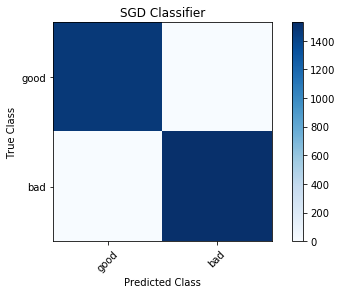

In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np

ref = [tag for (route, tag) in test_set]
test = [SGD_classifier.classify(route) for (route, tag) in test_set]

cm = nltk.ConfusionMatrix(ref, test)
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

sklcm = confusion_matrix(ref, test)
np.set_printoptions(precision=2)

def plot_cm(cm, classes, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    
plt.figure()
plot_cm(sklcm, classes=['good', 'bad'], title='SGD Classifier')
plt.show()